In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Disc-planet interaction

In this notebook, we will explore the interaction of test particles with an embedded planet numerically. As in the lectures, we will use the local model, so that the equations of motion for the test particles are
\\[
\ddot x - 2\Omega \dot y = 2\Omega S x - \frac{\partial \Phi_p}{\partial x},\\
\ddot y + 2\Omega \dot x = -\frac{\partial \Phi_p}{\partial y},
\\]
where \\(\Phi_p = -GM_p/\sqrt{x^2+y^2}\\) is the gravitational potential of the planet. We will stick to the Keplerian shear of \\(S = 3\Omega/2\\) in what follows. 

## Test particle encounter with planet

We first look at the encounter of a single test particle with the planet, starting the test particle at a particular \\(x=x_0\\) and far away from the planet in the \\(y\\) direction. In the figure below, vary the starting \\(x\\) to see how the orbit of the test particle is affected. The unit of distance is the Hill sphere, as derived in the lectures
\\[
R_H = \left(\frac{GM_p}{2S\Omega}\right)^{1/3}.
\\]
The red 'circle' denotes the size of the Hill sphere of the planet. Particles entering the Hill sphere will suffer very strong deflections! 

FloatText(value=3.0, description='Start x:')

Output()

<IPython.core.display.Javascript object>


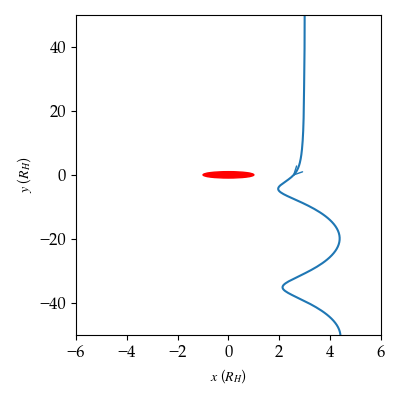

In [3]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode
from IPython.display import display, update_display, HTML
import ipywidgets as widgets

# Try and make plots look nice
plt.rcParams["font.family"] = 'serif'
plt.rcParams["mathtext.fontset"] = 'stix'
plt.rcParams["font.serif"] = 'Palatino'
plt.rcParams['pdf.fonttype'] = 42
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')

def f(t, y):
    res = 0.0*y
    
    res[0] = y[1]   # dx/dt = vx
    res[1] = 2*y[3] + 3*y[0] - 3*y[0]*np.power(y[0]*y[0] + y[2]*y[2], -1.5)
    res[2] = y[3]
    res[3] = -2*y[1] - 3*y[2]*np.power(y[0]*y[0] + y[2]*y[2], -1.5)
    
    return res

def integrate(x_start, y_max, tmax=100):
    y_start = y_max
    if (x_start < 0.0):
        y_start = -y_start
    
    y0, t0 = [x_start, 0.0, y_start, -1.5*x_start], 0.0
    r = ode(f).set_integrator('lsoda')
    r.set_initial_value(y0, t0)

    result = [y0]
    t = [t0]
    
    dt = 0.1
    while r.successful() and r.t < tmax:
        t.append(r.t + dt)
        result.append(r.integrate(r.t+dt))
        
    return np.asarray(t), np.asarray(result)

def add_arrow(line, position=None, direction='right', size=15, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = 0.0 #ydata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(ydata - position))
    #start_ind = np.int(len(ydata)/2)
    
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    return line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="->", color=color),
        size=size
    )

w_x0 = widgets.FloatText(
    value=3.0,
    description='Start x:',
    disabled=False
)
# Display widget
output = widgets.Output()
display(w_x0, output)

def int_xy(xs):
    t, result = integrate(xs, 50.0)

    x = result[:, 0]
    vx= result[:, 1]
    y = result[:, 2]
    vy= result[:, 3]
    
    return x, y

xs = 3.0
x, y = int_xy(xs)

fig = plt.figure(figsize=(4,4),num='Orbit')
ax = plt.gca()

circle = plt.Circle((0, 0), 1.0, color='r')
ax.add_artist(circle)

ax.set_xlabel(r'$x$ ($R_H$)')
ax.set_ylabel(r'$y$ ($R_H$)')
ax.set_xlim([-2*np.abs(xs), 2*np.abs(xs)])
ax.set_ylim([-50,50])

line, = ax.plot(x, y);

arrow = add_arrow(line)

plt.tight_layout()

# When slider is moved, update animation
def on_value_change(change):
    with output:
        global arrow 
        arrow.remove()
        
        xs = change['new']
        x, y = int_xy(xs)
        line.set_data(x, y)
        ax.set_xlim([-2*np.abs(xs), 2*np.abs(xs)])
        arrow = add_arrow(line)
        #ax.relim()
        #ax.autoscale()
                
w_x0.observe(on_value_change, names='value')

## Epicyclic oscillations

You have hopefully noticed that the particle starts to **oscillate** after its encounter with the planet. These oscillations are epicycles, and are the local equivalent of eccentric orbits. Therefore: particles pick up eccentricity when they encounter the planet. Note that this behaviour was completely absent in our impulse approximation. We will see below that this has quite a big impact.

The epicyclic oscillations also make it harder to directly compare the numerical results to the impulse approximation.  For example, look below at the evolution of the \\(x\\) velocity over time (the unit of time is chosen to be \\(\Omega^{-1}\\)). In the impulse approximation, we derived a definite change in \\(v_x\\):
\\[
\Delta v_x = - \frac{2GM_p}{S x_0^2}.
\\]
It clearly does not make sense to try and compare this in the presence of the oscillations. You can verify for yourself that the oscillation period is \\(2\pi/\Omega\\), independent of starting position. This confirms that these are epicycles.

FloatText(value=3.0, description='Start x:')

Output()

<IPython.core.display.Javascript object>


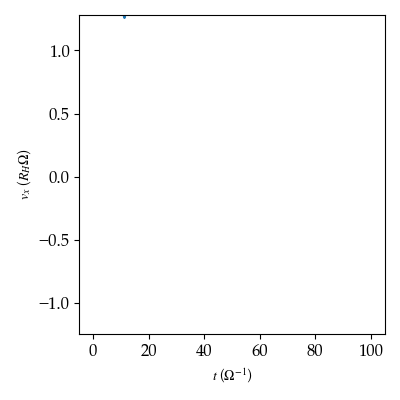

In [9]:
w_x1 = widgets.FloatText(
    value=3.0,
    description='Start x:',
    disabled=False
)

# Display widget
output = widgets.Output()
display(w_x1, output)

xs = 3.0
t, result = integrate(xs, 50.0)
x = result[:, 0]
vx= result[:, 1]
y = result[:, 2]
vy= result[:, 3]
    
fig2 = plt.figure(figsize=(4,4),num='x-velocity')
ax2 = plt.gca()

ax2.set_xlabel(r'$t$ ($\Omega^{-1}$)')
ax2.set_ylabel(r'$v_x$ ($R_H\Omega$)')

line2, = ax2.plot(t, vx)

plt.tight_layout()

# When slider is moved, update animation
def on_value_change(change):
    with output:
        xs = change['new']
        t, result = integrate(xs, 50.0)
        vx= result[:, 1]
         
        line2.set_data(t, vx)
        ax2.relim()
        ax2.autoscale()
                
w_x1.observe(on_value_change, names='value')

## Angular momentum evolution

How to get rid of these oscillations? The answer is to look at 'angular momentum' rather than velocities. This makes sense because epicyclic oscillations occur at constant angular momentum! The equivalent of angular momentum in the local model is 
\\[
p_y = v_y + 2\Omega x.
\\]
It is straightforward to show that in the absence of a planet, test particles have a constant \\(p_y\\) (just differentiate \\(p_y\\) with respect to time and use the equations of motion). Below you can see how \\(p_y\\) changes during an encounter. 

FloatText(value=3.0, description='Start x:')

Output()

<IPython.core.display.Javascript object>


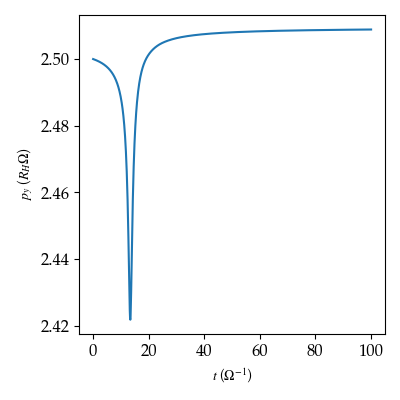

In [13]:
w_x2 = widgets.FloatText(
    value=3.0,
    description='Start x:',
    disabled=False
)

# Display widget
output = widgets.Output()
display(w_x2, output)

xs = 3.0
t, result = integrate(xs, 100.0)
x = result[:, 0]
vx= result[:, 1]
y = result[:, 2]
vy= result[:, 3]
  
py = vy + 2*x

fig3 = plt.figure(figsize=(4,4),num='Angular momentum')
ax3 = plt.gca()

ax3.set_xlabel(r'$t$ ($\Omega^{-1}$)')
ax3.set_ylabel(r'$p_y$ ($R_H\Omega$)')

line3, = ax3.plot(t, py)

plt.tight_layout()

# When slider is moved, update animation
def on_value_change(change):
    with output:
        xs = change['new']
        t, result = integrate(xs, 100.0)
        x = result[:, 0]
        vy= result[:, 3]
        
        py = vy + 2*x

        line3.set_data(t, py)
        ax3.relim()
        ax3.autoscale()
                
w_x2.observe(on_value_change, names='value')

Note that indeed angular momentum is oscillation free! In the impulse approximation, we neglect any change in \\(x\\), and hence the predicted change in \\(p_y\\) is the same as the predicted change in \\(v_y\\):
\\[
\Delta p_y = \Delta v_y = \frac{2(GM_p)^2}{S^3x_0^5}.
\\]
So how does the impulse approximation compare with the numerical result?

<IPython.core.display.Javascript object>


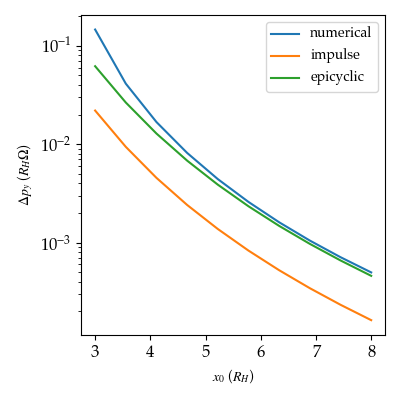

In [17]:
def torque(x_start):
    t, result = integrate(x_start, 10000.0, tmax=10000.0)
  
    x = result[:, 0]
    vx= result[:, 1]
    y = result[:, 2]
    vy= result[:, 3]

    py = vy + 2*x
    
    return py[-1] - py[0]

xs = np.linspace(3, 8, 10)
tq = 0.0*xs
for i in range(0, len(xs)):
    tq[i] = torque(xs[i])
  
fig4 = plt.figure(figsize=(4,4),num='Torque')
ax4 = plt.gca()
ax4.set_yscale('log')

ax4.set_xlabel(r'$x_0$ ($R_H$)')
ax4.set_ylabel(r'$\Delta p_y$ ($R_H\Omega$)')

ax4.plot(xs, tq, label='numerical')
S = 1.5
ax4.plot(xs, 8/S/xs**5, label='impulse')
ax4.plot(xs, 2*3.359*3.359/S/xs**5, label='epicyclic')

plt.legend()
plt.tight_layout()

The impulse approximation (orange curve) is off by a factor of a few. This was to be expected given the strong simplifications we made. A more complicated model, shown by the green curve, which takes into account the epicycles, gives
\\[
\Delta p_y = \frac{C^2(GM_p)^2}{2S^3x_0^5},
\\]
with \\(C=3.359\\) is a numerical value involving Bessel functions (again!). Note that this improved model gets very accurate towards large values of \\(x_0\\). Also note that the impulse approximation only gets the numerical prefactor wrong: the dependence on \\(x_0\\), \\(M_p\\) and \\(S\\) is the same!